In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

DATA_LOC = '../../../Data/microbiome_xai/'
DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"
FLUX_DF_NAME = "micom_medium-fluxes-top50-9285_samples_fd.csv"
FLUX_DF_NAME_all_FILT = "micom_fluxes-top50-9285_samples_fd_VEGAN-2000.csv"

gut_data = gd.GutData() # required to load for renaming metabolites as their id 
gut_data.load_data( 
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"
)

### Load flux dataframe
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False)
X_flux.index = X_flux.index.astype(str)
X_flux = mb_utils.drop_constant_cols(X_flux)

flux_df_foodids = X_flux.copy()
flux_df_foodids.columns = flux_df_foodids.columns.map(lambda x: x.replace("EX_", "").replace("_m__medium", "[e]"))

food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df.csv',index_col=0)
food_matrix_df.fillna(0, inplace=True)

### Load large flux dataframe 
# X_flux_notmedium = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME_all_FILT,index_col=0,low_memory=False)
# X_flux_notmedium.index = X_flux_notmedium.index.astype(str)

### Get list of consumed columns
# X_flux_consumed = X_flux[X_flux.columns[X_flux.mean()<0]].copy()
# X_flux_consumed_cols = [x.replace("EX_", "").replace("_m__medium", "[e]") for x in X_flux_consumed.columns]
# print("len(X_flux_consumed_cols):",len(X_flux_consumed_cols))

Fixed EX_tDHNACOA(e)


In [88]:
# gut_data.set_vegan_df(sample_num=1000)
# flux_df_foodids, y = mb_utils.match_Xy_df(flux_df_foodids, gut_data.X_df.copy())
# print(flux_df_foodids.shape)

(1135, 788)


In [111]:
lasso_alpha = 0.001
lasso = Lasso(alpha=lasso_alpha ,max_iter=1e5, normalize=True, tol=1e-4)

diet_df = pd.DataFrame()
score_dict = {}
for sample, flux_row in tqdm(flux_df_foodids[:].iterrows()):
    # print(sample, flux_row)
    flux_row_uptake = flux_row[flux_row<0] # look at only uptakes
    flux_row_uptake = flux_row_uptake*-1 # make positive to correspond to foods
    metab_overlap = list(set(flux_row_uptake.index).intersection(set(food_matrix_df.index)))
    y_df = flux_row_uptake.loc[metab_overlap].copy()
    A_df = food_matrix_df.loc[metab_overlap].copy()
    
    lasso.fit(A_df,y_df)
    score_val = lasso.score(A_df,y_df)
    score_dict.update({sample: score_val})
    x_pred_signal = pd.Series(lasso.coef_, index=A_df.columns)
    x_pred_signal.name = sample
    diet_df = pd.concat([diet_df, x_pred_signal],axis=1)
    
diet_df = diet_df.T
score_df = pd.Series(score_dict)

43it [00:04,  8.76it/s]/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.203601007210182, tolerance: 0.5512633121862215
  model = cd_fast.enet_coordinate_descent(
4554it [12:13,  7.41it/s]/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.9623628908912, tolerance: 0.7728684690988679
  model = cd_fast.enet_coordinate_descent(
9169it [30:42,  2.96it/s]/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.56618076949053, tolerance: 1.0713304183361065
  model = cd_fast.enet_coordinate_descent(
9285i

In [112]:
diet_df.to_csv(gut_data.dir_sim_data+"diet_df.csv")
score_df.to_csv(gut_data.dir_sim_data+"diet_score_df.csv")

<AxesSubplot:>

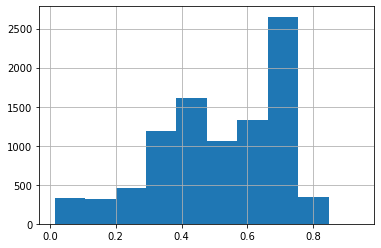

In [115]:
score_df.hist()

# ML using computed diets

Filter for samples that have R2>0.4?

In [2]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest

def get_imp_feature_series(X, n_scores, FEAT_FILTER_TYPE):
    feat_df = pd.DataFrame()

    for est_i in range(len(n_scores["estimator"])):
        if FEAT_FILTER_TYPE == "SelectKBest":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE.lower()].get_support()],name=est_i)
        elif FEAT_FILTER_TYPE == "RFE":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE.lower()].support_],name=est_i)
        feat_df = pd.concat([feat_df, feat_series_df],axis=1)

    feat_df.fillna(0, inplace=True)
    feat_df_avg = feat_df.mean(axis=1)
    return feat_df_avg

In [3]:
diet_df = pd.read_csv(gut_data.dir_sim_data+"diet_df.csv", index_col=0, low_memory=False)
diet_df = mb_utils.drop_constant_cols(diet_df)
diet_df.shape

(9285, 587)

In [4]:
gut_data.set_vegan_df(sample_num=10000)

N_SPLITS = 50 #10
TEST_SIZE = 0.25
N_FEATURES = 400

model_logreg_fit = LogisticRegression(
    C=1, class_weight='balanced', intercept_scaling=True, max_iter=1000, solver='liblinear',penalty = "l2")
score_list = ['accuracy','balanced_accuracy','roc_auc','average_precision', 'f1', 'f1_weighted']
skf = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE)
X, y = mb_utils.match_Xy_df(diet_df.copy(), gut_data.y_df.copy())


model = make_pipeline(StandardScaler(), SMOTE(), SelectKBest(f_classif, k=N_FEATURES), model_logreg_fit)
n_scores = cross_validate(model, X, y, scoring=score_list, cv=skf, n_jobs=-1, error_score='raise', return_estimator=True)
score_dict = {score_id: n_scores["test_"+score_id] for score_id in score_list}

imp_feat_df = get_imp_feature_series(X, n_scores, "SelectKBest")

# coef_df = pd.Series(model_logreg_fit.coef_[0], index=diet_df.columns)

In [135]:
y.sum()/y.shape[0]

0.0232722143864598

In [5]:
pd.DataFrame(score_dict).mean()

accuracy             0.743531
balanced_accuracy    0.506536
roc_auc              0.508053
average_precision    0.027896
f1                   0.044372
f1_weighted          0.833133
dtype: float64

In [8]:
imp_feat_df.sort_values() #[:10]

Mikan                     -3.839665
Brussel sprouts           -2.588086
Tamarind                  -2.109802
Tartary buckwheat         -2.090418
Broad bean                -1.869404
                             ...   
Pomegranate                2.092405
Onion-family vegetables    2.539480
Fats and oils              2.558836
Chineese plum              2.750690
Oil-seed Camellia          2.870986
Length: 512, dtype: float64

<AxesSubplot:>

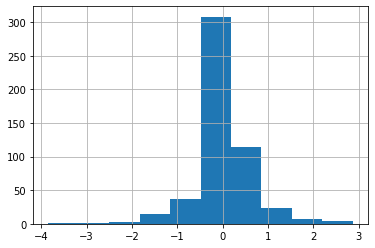

In [9]:
imp_feat_df.hist()

In [7]:
coef_df.sort_values()[-10:]

NameError: name 'coef_df' is not defined

In [71]:
model_logreg_fit.score(diet_df, y_df)

0.6275510204081632

In [6]:
diet_df = mb_utils.drop_constant_cols(diet_df)
f_stat, p_val = f_classif(diet_df, y_df)
#fclass_df = pd.DataFrame(f_stat, index=X.columns, columns=["f_stat"])
fclass_pval_df = pd.Series(p_val, index=diet_df.columns)
fclass_pval_df.name = "pval"
# fclass_df = pd.DataFrame([f_stat, p_val], index=X.columns, columns=["f_stat", "p_val"])
fclass_pval_df.sort_values()

NameError: name 'y_df' is not defined

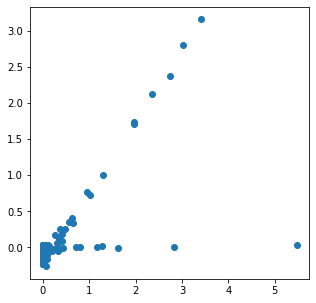

In [38]:
y_pred = A_df.dot(lasso.coef_)
f, ax = plt.subplots(1, 1, figsize=(5, 5)) # 5 works well for n_feats=10
ax.scatter(y_df, y_pred)

<AxesSubplot:>

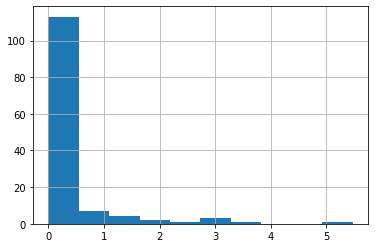

In [23]:
y_df.hist()

In [46]:
diet_df

,10317.000050161,10317.000029319,10317.000073912,10317.000046936,10317.000046359,10317.000044832,10317.000047251,10317.000023086,10317.000076488,10317.000023082,...,10317.000087669,10317.000014150,10317.000022629,10317.000016258,10317.000092655,10317.000026657,10317.000029186,10317.000046876,10317.000097817,10317.000036977
Abalone,-0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.0,0.000000
Abiyuch,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,0.0,-0.000000,-0.0,...,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
Acerola,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,0.0,-0.000000,-0.0,...,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
Acorn,-0.0,0.000000,0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,...,0.000000,0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.000000
Acorn squash,-0.0,-0.000000,-0.0,0.000000,-0.0,-0.000000,0.0,-0.0,-0.061328,-0.0,...,-0.013415,-0.0,-0.049934,-0.000000,-0.0,-0.010556,-0.000000,-0.000000,-0.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yellowfin tuna,-0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.000000,-0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.0,0.000000
Yellowtail amberjack,-0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.000000,-0.0,...,0.000000,0.0,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000,-0.0,0.000000
Ymer,-0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,-0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,-0.0,0.000000,0.000000,0.000000,-0.0,0.000000
Yogurt,0.0,-0.000000,-0.0,0.000000,-0.0,0.000000,0.0,-0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,-0.0,0.000000,0.000000,0.000000,0.0,0.000000


In [21]:
diet_df.sort_values(by=sample)

,10317.000050161
Millet,-0.004398
Red beetroot,-0.003232
Smelt,-0.003134
Rabbiteye blueberry,-0.002828
Corn salad,-0.002318
...,...
Butternut,0.001279
Opium poppy,0.001844
"Scombridae (Bonito, Mackerel, Tuna)",0.002681
Beluga whale,0.003246


In [16]:
A_df

,Abalone,Abiyuch,Acerola,Acorn,Acorn squash,Adobo,Adzuki bean,Agar,Agave,Akutaq,...,Yautia,Yellow bell pepper,Yellow pond-lily,Yellow wax bean,Yellow zucchini,Yellowfin tuna,Yellowtail amberjack,Ymer,Yogurt,Zwieback
source_id,,,,,,,,,,,,,,,,,,,,,
gua[e],1.0,1.0,1.0,1.0,NaN,NaN,1.0000,1.000000,1.0,NaN,...,1.00,1.000000,1.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
4hpro_LT[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.880000,NaN,0.800000,0.665000,NaN,NaN,NaN,NaN,NaN
asn_L[e],1.0,1.0,1.0,1.0,NaN,NaN,1.0000,1.000000,1.0,NaN,...,1.00,1.000000,1.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
isoval[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ocdcea[e],NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000000,NaN,NaN,...,NaN,96.800000,NaN,NaN,117.750000,NaN,NaN,616.5,642.300000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ca2[e],34.0,8.0,11.0,46.0,NaN,123.0,41.3375,456.333333,549.0,12.0,...,383.15,23.605436,25.0,50.692308,27.914007,4.0,26.0,196.0,129.622414,20.0
ser_D[e],1.0,1.0,1.0,1.0,NaN,NaN,1.0000,1.000000,1.0,NaN,...,1.00,1.000000,1.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
glypro[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
y_df

gua[e]        -1.025302e-03
4hpro_LT[e]   -2.345858e-03
rib_D[e]       3.845889e-05
asn_L[e]      -1.024765e+00
so3[e]         1.586585e-09
                   ...     
succ[e]        3.172816e-04
ptrc[e]       -1.017259e-01
tym[e]        -3.452348e-06
diact[e]       5.505728e-06
oxa[e]         6.731736e+00
Name: 10317.000050161, Length: 207, dtype: float64

In [4]:
flux_row_uptake = flux_row[flux_row<0]

In [5]:
flux_row_uptake

EX_12dgr180_m__medium      -5.652487e-01
EX_12ppd_S_m__medium       -3.752960e-06
EX_15dap_m__medium         -6.696037e-06
EX_1hibupglu_S_m__medium   -2.286949e-06
EX_1hmdgluc_m__medium      -2.096983e-06
                                ...     
EX_xylan_m__medium         -1.017260e-06
EX_xylottr_m__medium       -6.960025e-07
EX_xylt_m__medium          -2.490770e-08
EX_xyluglc_m__medium       -1.421552e-08
EX_zn2_m__medium           -1.301335e-01
Name: 10317.000050161, Length: 472, dtype: float64

In [6]:
food_matrix_df.head()

,Abalone,Abiyuch,Acerola,Acorn,Acorn squash,Adobo,Adzuki bean,Agar,Agave,Akutaq,...,Yautia,Yellow bell pepper,Yellow pond-lily,Yellow wax bean,Yellow zucchini,Yellowfin tuna,Yellowtail amberjack,Ymer,Yogurt,Zwieback
source_id,,,,,,,,,,,,,,,,,,,,,
estrone[e],1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
for[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dms[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hom_L[e],1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
cholate[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
food_signal_df = mb_utils.food_lasso(y_df, A_df, SAVE_LOC_LASSO, SAVE_ID_ALPHA=SAVE_ID_ALPHA,SAVE_FIG=False)